# Fatal Police Shootings in the US #

## 1. Introduction

In the years 2015, 2016, and 2017 there were 2945 people killed in fatal police shootings in the United states according to [The Washington Post](https://www.washingtonpost.com/graphics/national/police-shootings/).  
Where there were 995 people killed in 2015, 963 people killed in 2016, and 987 people killed in 2017. As we can see from those numbers there is little change from year to year in police fatal shootings.  
In this report we will dive deeper into this, and try to answer the question in which state it is best to live in to avoid fatal police shootings.

## 2. About

### 2.1 Data
The data used for measurement is received from three sources [KFF population distribution 2017](https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D) which contains information about the distribution of differnet races in the united states, [enchantedLearning population 2017](https://www.enchantedlearning.com/usa/states/population.shtml) which includes population in USA and the main data set from kaggle [fatal police shootings in the us](https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us/version/1)
which includes data about police shootings in the United States but also has some additional information regarding various information about the incident. The kaggle dataset also contains information about the city the incident occurred in, such as median income, percentages of how many completed high school.

## 3. Preparing the data

### 3.1 Import the necessary libraries

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
import copy 
import warnings


### 3.2 Import the data sets

In [2]:
# Read the datasets
shootings_df = pd.read_csv('resources/PoliceKillingsUS.csv',encoding="windows-1252",parse_dates=[2])
medianIncome_df = pd.read_csv('resources/MedianHouseholdIncome2015.csv',encoding="windows-1252")
povertyLevel_df = pd.read_csv('resources/PercentagePeopleBelowPovertyLevel.csv',encoding="windows-1252")
race_distribution_df = pd.read_csv('resources/raceByUS.csv', encoding="utf-8")
population_by_state_df = pd.read_csv('resources/state_population.csv')
USPopulation2017_df = pd.read_csv('resources/USPopulation2017.csv', thousands=",")

### 3.3 Basic cleaning of the data

In [3]:
# Shootings_df

# We have no use for the id and name of the person columns so we decided to remove them
shootings_df = shootings_df.drop(['id','name'], axis=1)

# MedianIncome_df
# There are some values with '-' or '(x)' in them, so we remove them
medianIncome_df['Median Income'] = medianIncome_df['Median Income'].apply(lambda x : x if str(x).isdigit() else None)
medianIncome_df.dropna(inplace=True)

# povertyLevel_df
# There are some values with '-' in them, so we remove them
povertyLevel_df['poverty_rate'] = povertyLevel_df['poverty_rate'].apply(lambda x : x if '-' not in x else None)
povertyLevel_df.dropna(inplace=True)

# Hide the warning for the median income distribution plot
warnings.filterwarnings('ignore')

## 4. Where is the best and worst place to live according to fatal police shootings

In this section we will take a look at the datasets we have and dive into various interesting questions where we work our way to answering the main question, __where to live to avoid fatal police shootings?__

### 4.1 Answering the question using the shootings data

In this section we will only be using the shootings data to answer interesting questions about fatal police shootings incidents, which as you can see in the table below has information
about how many were killed in fatal police shootings, as well as additional information such as age, gender, 
race, the state it took place,if the suspect was armed and more. 

In [4]:
shootings_df.head(10)

,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,2015-02-01,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,2015-02-01,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,2015-03-01,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,2015-04-01,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,2015-04-01,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False
5,2015-04-01,shot,gun,18.0,M,W,Guthrie,OK,False,attack,Not fleeing,False
6,2015-05-01,shot,gun,22.0,M,H,Chandler,AZ,False,attack,Car,False
7,2015-06-01,shot,gun,35.0,M,W,Assaria,KS,False,attack,Not fleeing,False
8,2015-06-01,shot,unarmed,34.0,F,W,Burlington,IA,False,other,Not fleeing,True
9,2015-06-01,shot,toy weapon,47.0,M,B,Knoxville,PA,False,attack,Not fleeing,False


### 4.2 Interesting questions using the dataframe

Here below we will ask interesting questions and answering them in a visual way, the questions are: 
* How are the shootings divided by race?
* Is it more likely to be shot if you are a man?
* What state has the most fatal police shootings?


#### 4.2.1 Divison of races

For the last five years an international activist [black lives matter](https://en.wikipedia.org/wiki/Black_Lives_Matter) movement have gained alot of attention through social media platforms and the news. This movement campains against violence and systemic racism towards black people.
In this chapter we will take a closer look at the divison of races in the United States regarding fatal police shootings, and see if there is much difference in the distribution of races.


To show the difference between the races that are killed in police shootings from the data set we have decided to plot a pie chart which shows the percentages of each race killed in police shootings.     

The race in the shootings dataset sometimes contains other as a race value, which has no meaning to us. Therefore we will remove the row that contains other as a race before we start working the dataset.

In [5]:
# Remove rows that contain Other in the race column
shootings_race_df = shootings_df[shootings_df.race != 'O']
# Print how many rows we had to remove
print('Removed', shootings_df.shape[0]-shootings_race_df.shape[0],'rows containing other as a race')

Removed 28 rows containing other as a race


In [6]:
def raceLabelToRace(raceLabel):
    if(raceLabel == 'W'):
        return 'White'
    if(raceLabel == 'B'):
        return 'Black'
    if(raceLabel == 'N'):
        return 'Native American'
    if(raceLabel == 'A'):
        return 'Asian'
    if(raceLabel == 'H'):
        return 'Hispanic'

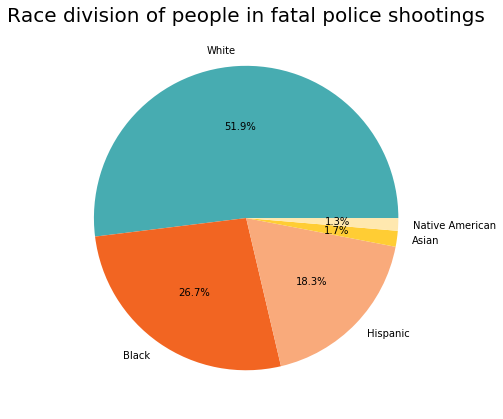

In [7]:
# Race rates  
labels = shootings_race_df['race'].value_counts().index
# Change the labels we have to words, for easier reading
labels = [raceLabelToRace(x) for x in labels]
colors = ['#47ACB1', '#F26522', '#F9AA7B', '#FFCD34','#FFE8AF']
values = shootings_race_df['race'].value_counts().values

# Plotting the pie chart
plt.figure(figsize = (7, 7))
plt.pie(values, labels = labels, colors = colors, autopct = '%1.1f%%')
plt.title('Race division of people in fatal police shootings', color = 'black', size = 20)
plt.show()

As we can see from the pie chart above, the majority or 51,9% of races killed in police shootings are categorized as white. By looking only at this data we would assume that it is more likely for people with white skin to be involved in a fatal police shooting.  
Despite the results we can read from the pie chart above, it is unfair to assume that it is more likely that you are to fall victim of a fatal police shooting if you are white, since the majority of people living the United states have white skin
according to [KFF Population Distribution by Race/Ethnicity](https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D). The race distribution in the United states can be seen in the table below.
We will then use this to get a more fair estimate of what race is more likely to be killed in a police shooting.

By looking at the table below we can see the average race division in the United States,
where 61% percentage of people living in the US are white.
To make a fair estimate we must therefore divide the number of fatal police shootings by the number of people in each race and calculate the new estimations.  
We know the population of each state in 2017 from this website [enchantedLearning.com](https://www.enchantedlearning.com/usa/states/population.shtml), and can then use that data to calculate how many are living in the US in 2017.



In [8]:
# Get how many are living in USA 2017
totalUsPopulation = USPopulation2017_df['Population (2017)'].sum()
race_distribution_df

,Location,White,Black,Hispanic,Asian,American Indian/Alaska Native,Native Hawaiian/Other Pacific Islander
0,United States,0.61,0.12,0.18,0.06,0.01,<.01


In [9]:
# Calculate how likely you are to be involved in a fatal police shooting for each race.
def oddsOfRaceKillings(raceLetter):
    result = ((shootings_race_df[shootings_race_df['race'] == raceLetter].shape[0])/(totalUsPopulation*race_distribution_df[raceLabelToRace(raceLetter)]))
    result = result[0]
    return (result*1000,result*10000, result*100000, result*1000000)

# Create a dataframe to display the killings of different races in police shootings
d = {'Per N citizens':['1k','10k','100k','1M'], 'White': list(oddsOfRaceKillings('W')),
     'Black': list(oddsOfRaceKillings('B')), 'Hispanic': list(oddsOfRaceKillings('H')),
     'Asian': list(oddsOfRaceKillings('A'))}
dff = pd.DataFrame(data=d)
dff


,Per N citizens,White,Black,Hispanic,Asian
0,1k,0.006045,0.015811,0.007215,0.001996
1,10k,0.060446,0.158112,0.072148,0.019956
2,100k,0.604463,1.581117,0.721480,0.199558
3,1M,6.044632,15.811166,7.214804,1.995584


In the table above we can see how many are killed in a police shooting, where the table describes how many are killed per N citizens, for example if we look at row three we see that there are 6 white people killed by the police per one million citizens.  
We can see that the results of what race were the most involved in fatal police shootings have changed quite drastically. In the pie plot above the white race was much more involved in fatal police shootings than the other races. After calculating the race distribution with population of each race we can see that people with black skin are almost three times more often killed in a police shooting than white skinned and two times more often than hispanic people.

#### 4.2.2 Is it more likely to be in a fatal police shooting if you are a man?

In this chapter we will take a look at if it makes a difference whether, and if you are more likely to be in a fatal police shooting if you are a man.
We will do so by taking a look at the distribution of the genders in the dataset of police shootings in the US, and displaying the results in a bar plot.

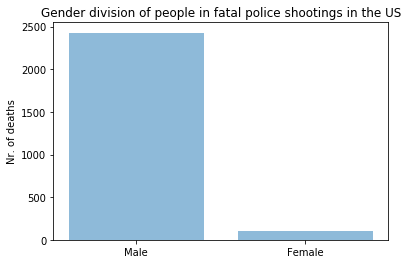

In [10]:
# Create the labels
Labels = ('Male','Female' )
y_pos = np.arange(len(Labels))
# Get the values of how many were killed of each gender
performance = shootings_df['gender'].value_counts().tolist()
# Create the bar plot
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, Labels)
plt.ylabel('Nr. of deaths')
plt.title('Gender division of people in fatal police shootings in the US')
 
plt.show()

As we can see from the bar plot above, the majority of people killed in police shootings are male, where the data shows us that there were around 2400 males and around 100 females killed.  
This shows us that it is much less likely to be killed in police shootings if you are a female than a male.


#### 4.2.3 Fatal police shootings according to state

In each state the amount of fatal police shootings is different and may be more frequent in some states than others, therefore it is interesting to look at the distribution of how many were killed in each state.  
In this chapter we will take a look at the number of fatal police shootings in each state, and visualize it using a bar plot.

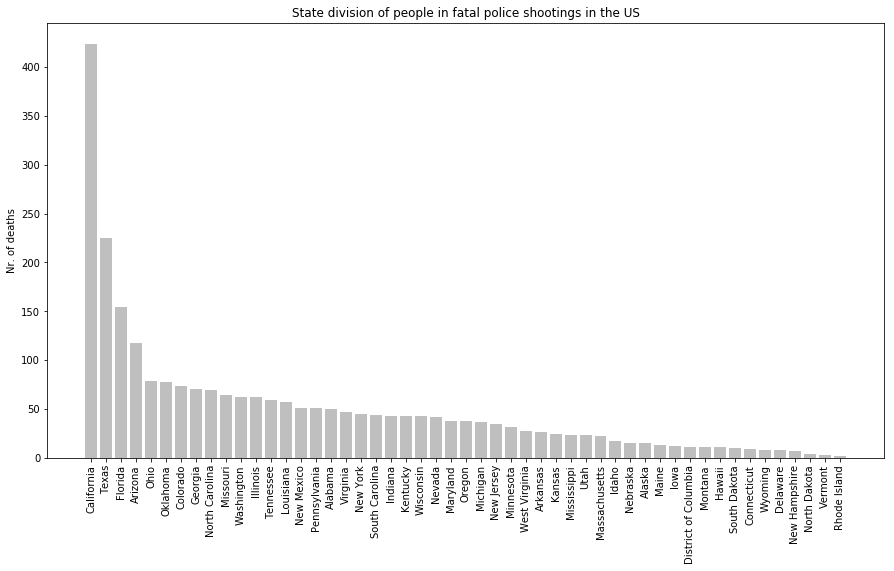

In [11]:
# Create a states dictionary to convert from abbreviations to full names of states
states = {'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa','AZ': 'Arizona','CA': 'California','CO': 'Colorado','CT': 'Connecticut','DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','GU': 'Guam','HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri','MP': 'Northern Mariana Islands','MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina','ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VA': 'Virginia','VI': 'Virgin Islands','VT': 'Vermont','WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'}
# Change abbreviations of states to state names
states_shootings_df = shootings_df.state.apply(lambda x : states[x] if x in states else x)
# Create the labels
Labels = states_shootings_df.value_counts().index.tolist()
y_pos = np.arange(len(Labels))
# Get the values of how many were killed of each gender
performance = states_shootings_df.value_counts().tolist()
# Create the bar plot
plt.figure(figsize = (15, 8))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='gray')
plt.xticks(y_pos, Labels, rotation=90)
plt.ylabel('Nr. of deaths')
plt.title('State division of people in fatal police shootings in the US')
 
plt.show()

As we can see in the bar plot above there is a huge difference in the amounts of deaths in police shootings depending on the state.
We can see that the state with the largest number of deaths by police shootings is with out a doubt the state of California, followed by Texas and the lowest number of deaths is in the  state of Rhode Island.

#### 4.2.4 Diving deeper into state divison of fatal police shootings

To make a fair estimate of what state has the most fatal police shootings according to population, we must take into account how many people live in each state, we can do so by looking up for each state how many live in that state. From there we can divide the number of fatal police shootings by the population of each state to get the probability of being in a fatal accident with the police in each state.

In [12]:
# Create new df and change the state to real name of state
us_shootings_df = shootings_df
us_shootings_df['state'] = shootings_df.state.apply(lambda x : states[x] if(x in states) else x)
# Create dictionary out of how many occurences we have in each state
StateOccurranceDict = dict(us_shootings_df['state'].value_counts())

In [13]:
# Remove the ',' in each population_estimate so we can calculate it
population_by_state_df['population_estimate'] = population_by_state_df['population_estimate'].str.replace(',', '')

# Create array to keep track of probability of being killed in police shooting for each state
prob_of_death_per_state = []

# Calculate the probability of being killed in each state
for index, row in population_by_state_df.iterrows():
    # if state is in dictionary calculate probability
    if(StateOccurranceDict[row['state']]):
        prob_of_death_per_state.append((row['state'],(float(StateOccurranceDict[row['state']])/float(row['population_estimate']))))
            

In [14]:
#Create dataframe from percentage calculations
states_prob_df = pd.DataFrame(prob_of_death_per_state, columns=['state', 'probability_of_fatal_shooting (%)'])  
# Format the probability column so it displays the result in human readable form
states_prob_df['probability_of_fatal_shooting (%)'] = states_prob_df['probability_of_fatal_shooting (%)'].apply(lambda x : "{:.5%}".format(x))
states_prob_df['probability_of_fatal_shooting (%)'] = states_prob_df['probability_of_fatal_shooting (%)'].apply(lambda x : x.replace('%',''))

In [15]:
result = states_prob_df.sort_values(by=['probability_of_fatal_shooting (%)'], ascending=True)
result.head(10)

,state,probability_of_fatal_shooting (%)
39,Rhode Island,0.00019
34,New York,0.00023
6,Connecticut,0.00025
19,Massachusetts,0.00032
22,Michigan,0.00037
12,Iowa,0.00038
31,New Jersey,0.00039
38,Pennsylvania,0.00040
46,Vermont,0.00048
14,Illinois,0.00049


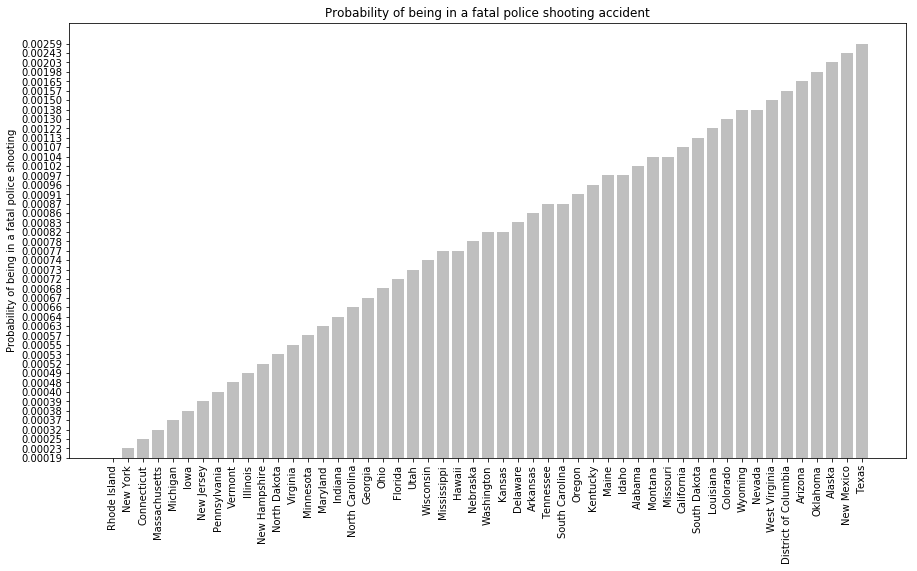

In [16]:
# Create the labels
Labels = result['state'].tolist()
y_pos = np.arange(len(Labels))
# Get the values of how many were killed of each gender
performance = result['probability_of_fatal_shooting (%)'].tolist()
# Create the bar plot
plt.figure(figsize = (15, 8))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='grey')
plt.xticks(y_pos, Labels, rotation=90)
plt.ylabel('Probability of being in a fatal police shooting')
plt.title('Probability of being in a fatal police shooting accident')
 
plt.show()

As we can see in the bar plot above after calculating the probability of being in a fatal police shooting accident by each state, the state with the highest probability of people killed is Texas with 0.00259% of being killed in a police shooting. The state with the lowest probability is Rhode Island with 0.00019% of being killed in police shooting.
By comparing the two bar plots we can see there are major changes for some states, for example California in the previous bar plot had the highest number of people killed in police shootings, while it is now in 13'th place in the new bar plot which takes into account how many people live in the state.
Which shows us that the population matters alot when comparing which state has the lowest and highest fatal police shootings.

### 4.3 Answering the question using the median income data

Does it make a difference if the median income in a state is higher regarding to being killed in a police shooting?  
We will answer this question by taking a look at the median income of each state in the United States and comparing the state's income to how many fatal police shootings were in that state.

In [17]:
medianIncome_df.head(10)

,Geographic Area,City,Median Income
0,AL,Abanda CDP,11207
1,AL,Abbeville city,25615
2,AL,Adamsville city,42575
3,AL,Addison town,37083
4,AL,Akron town,21667
5,AL,Alabaster city,71816
6,AL,Albertville city,32911
7,AL,Alexander City city,29874
8,AL,Alexandria CDP,56058
9,AL,Aliceville city,21131


In the table above we can see how a subset of our median income dataset looks like, we have information about the
states, what cities and what the median income is of most of the cities in the US.

#### 4.3.1 Missing values of median income dataset

In our dataset about median income of the cities in the United States we have some missing data, which means we either have to take out the lines with missing income or try to guess what those numbers should be.  
In this subchapter we will try using a linear regression classifer to predict what the median income for the cities that are missing median_income data, by trying to find a correlation between the cities in each state and the median income in that state.

In [18]:
medianIncome_df = medianIncome_df.rename(index=str, columns={"Median Income": "Median_Income", "Geographic Area": "Geographic_Area"})
medianIncome_df['Median_Income'] = medianIncome_df['Median_Income'].apply(lambda x : float(x))

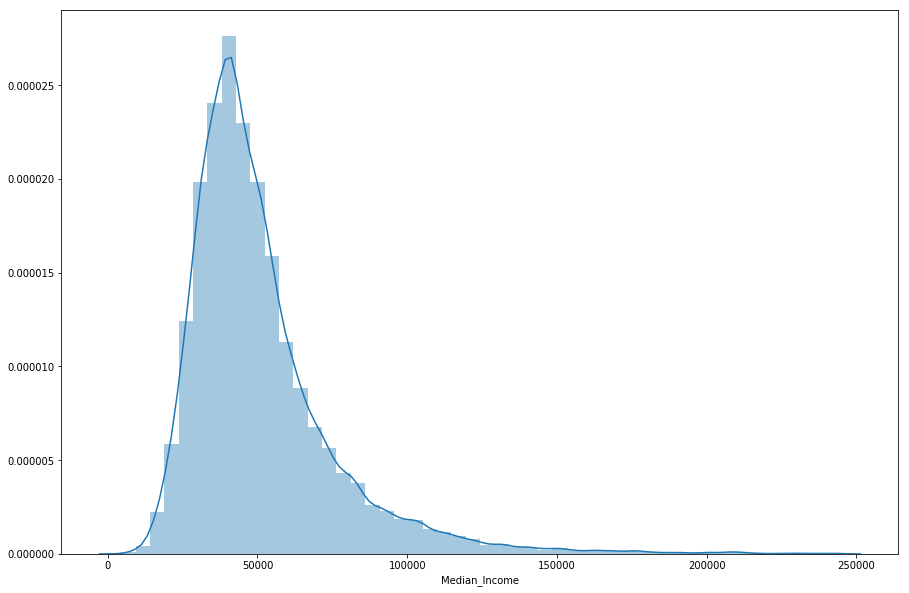

In [19]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(medianIncome_df['Median_Income'])

In this plot we can see the distribution of the median income, and we can see that most of the cities have around \$ 50.000 in yearly income, which might make our classifer more biased to predicting numbers around that area.

In [20]:
# Create temp dictionary so we can change the categorical data
# into numerical values
statestest = {'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa','AZ': 'Arizona','CA': 'California','CO': 'Colorado','CT': 'Connecticut','DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','GU': 'Guam','HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri','MP': 'Northern Mariana Islands','MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina','ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VA': 'Virginia','VI': 'Virgin Islands','VT': 'Vermont','WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'}
count= 1
# Replace the values of the dictionary with counter++
for x in statestest:
    statestest[x] = count
    count += 1
# Change the dataframe['Geographic_Area'] to numerical values
medianIncomeClassdf = copy.deepcopy(medianIncome_df)
medianIncomeClassdf['Geographic_Area'] = medianIncomeClassdf['Geographic_Area'].apply(lambda x : statestest[x] if x in statestest else x)

In [21]:
# Reshape Geographic_Area data
X = medianIncomeClassdf['Geographic_Area'].values.reshape(-1,1)
# Reshape Median_Income data
y = medianIncomeClassdf['Median_Income'].values.reshape(-1,1)

In [22]:
# Split the data into x-training and testing set and y-training and testing set devidi the data 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
# Create instance of linear regression
regressor = LinearRegression() 

In [24]:
# Train the algorithm
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [25]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

[49909.88493]
[[47.93000268]]


In [26]:
# Make predictions on the data
y_pred = regressor.predict(X_test)

In [27]:
# Create a new dataframe to compare the actual and predicted data
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.head(10)

,Actual,Predicted
0,31042.0,52114.665053
1,104276.0,51970.875045
2,75383.0,51827.085037
3,30625.0,51203.995002
4,72900.0,51922.945043
5,26500.0,51875.015040
6,71667.0,51779.155035
7,80000.0,51539.505021
8,59464.0,51443.645016
9,28365.0,51299.855008


Our classifier is as we expected classifying towards the most frequent median income, which is to be expected when the majority of the data is around \$50.000 classifier will predict a value around that.


In [28]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 17107.88038395868


By calculating the mean absolute error, the average vertical distance between each point and the identity line, we can see that the classifier is off by around \$17.000.
For this dataset we find that the classifier is not good enough to fill in the missing median values for the cities so we have decided to remove the rows containing the missing data (which has been done in the Basic cleaning of the data section).

#### 4.3.2 Where is the highest  and lowest median income

In each city the median income is different and it might make a difference on how much crime, and therefore how many fatal police shootings occur in each city. In this chapter we will look at the state with the highest
and lowest median incomes. To find the median income for each state we must sum up the median income for all cities in the state and divide by the number of cities. 

In [29]:
# Drop unnecessary column, and convert median income to float for calculation
median_income_by_state = medianIncome_df.drop(['City'], axis=1)
median_income_by_state['Median_Income'] = median_income_by_state['Median_Income'].apply(lambda x: float(x))

In [30]:
# Calculating the median income for each state
median_income_by_state = median_income_by_state.groupby(['Geographic_Area']).mean().reset_index()
# Convert from abbreviations to full names of states
median_income_by_state['Geographic_Area'] = median_income_by_state['Geographic_Area'].apply(lambda x: states[x] if x in states else x)
# Create df with the 10 largest median income
largest_median_income_by_state = median_income_by_state.nlargest(10, 'Median_Income')
# Create df with the 10 smallest median income
smallest_median_income_by_state = median_income_by_state.nsmallest(10, 'Median_Income')

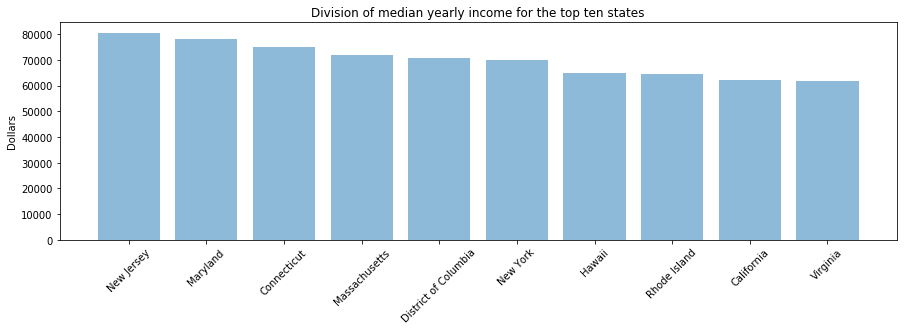

In [31]:
# Create the labels
Labels = (largest_median_income_by_state['Geographic_Area'].tolist())
y_pos = np.arange(len(Labels))
# Get the value of median income for each state
performance = largest_median_income_by_state['Median_Income'].tolist()
# Create the bar plot
plt.figure(figsize = (15, 4))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, Labels, rotation=45)
plt.ylabel('Dollars')
plt.title('Division of median yearly income for the top ten states')
 
plt.show()

From the bar plot above we can see that the top ten states with the highest yearly median income range from 80.000 to 60.000 dollars where New Jersey has the highest and Virginia is the lowest of the top ten states.

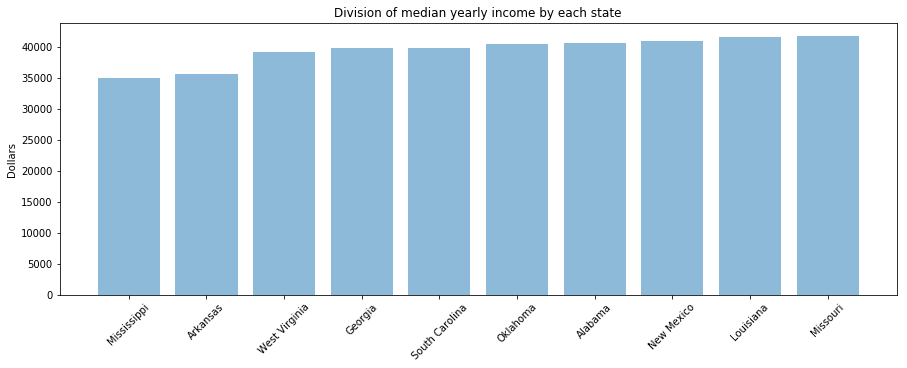

In [32]:
# Create the labels
Labels = (smallest_median_income_by_state['Geographic_Area'].tolist())
y_pos = np.arange(len(Labels))
# Get the value of median income for each city
performance = smallest_median_income_by_state['Median_Income'].tolist()
# Create the bar plot
plt.figure(figsize = (15, 5))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, Labels, rotation=45)
plt.ylabel('Dollars')
plt.title('Division of median yearly income by each state')
 
plt.show()

The bar plot above shows us the ten lowest states regarding median yearly income. The lowest states range from 41.000 down to 35.000 dollars.
By comparing the two plots we can see that there is significant difference between the top ten and lowest ten states regarding median yearly income.

#### 4.3.3 Is it better to live in a place with higher income

Given the data we have gathered it would be interesting to look at the correlation between each state's median income versus the number of fatal police shootings. 
We will do so in this chapter by making a scatter plot where the axis represent median income and number of fatal shootings.

In [33]:
# Sort shootings df by state, so that we can plot it correctly
results_shootings = shootings_df.sort_values(by=['state'], ascending=True)
# Sort median income by state
results_median_income = median_income_by_state.sort_values(by=['Geographic_Area'],ascending=True)

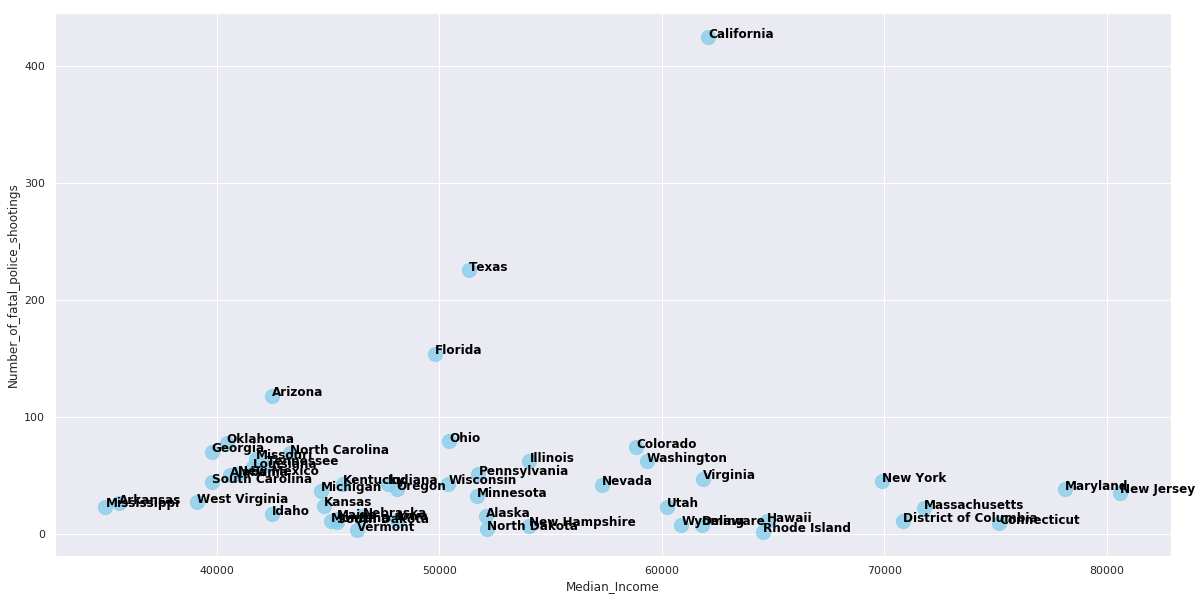

In [34]:
# Create dataframe for plotting
df = pd.DataFrame({
# Create the x-axis
'Median_Income': results_median_income['Median_Income'].tolist(),
# Create the y-axes
'Number_of_fatal_police_shootings': results_shootings['state'].value_counts().sort_index().tolist(),
# Create the labels for each state
'group': results_shootings['state'].value_counts().sort_index().index.tolist()
})
# Setting the size of the scatter plot
sns.set(rc={'figure.figsize':(20,10)})
# Plotting the data points
p1=sns.regplot(data=df, x="Median_Income", y="Number_of_fatal_police_shootings", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})

# Add annotations for each states
for line in range(0,df.shape[0]):
     p1.text(df.Median_Income[line]+0.2, df.Number_of_fatal_police_shootings[line], df.group[line], horizontalalignment='left', size='medium', color='black', weight='semibold')




From the scatter plot above we can see that there is little to no correlation between median income and number of people killed in police shooting. If we look at for example Massachusetts which has around 73.000 dollars in median income and West Virginia which has around 38.000 dollars in median income we can see they have similar number of people killed in police shootings.

### 4.4 Police shootings with poverty levels

In this chapter we will go over the data which contains information about poverty level.  
But what is poverty?
Poverty is about not having enough money to meet basic needs including food, clothing and shelter.  
The poverty level data provides poverty_rate for each city in the United States. The poverty_rate describes how many percentages of people in the corrosponding state are below poverty level.  
Here below you can see the first 10 lines in the dataframe for better understanding of what data we got.

In [35]:
povertyLevel_df.head(10)

,Geographic Area,City,poverty_rate
0,AL,Abanda CDP,78.8
1,AL,Abbeville city,29.1
2,AL,Adamsville city,25.5
3,AL,Addison town,30.7
4,AL,Akron town,42
5,AL,Alabaster city,11.2
6,AL,Albertville city,26.7
7,AL,Alexander City city,30.4
8,AL,Alexandria CDP,9.7
9,AL,Aliceville city,41.3


#### 4.4.1 Where is the highest poverty rate

Here below we will take a look at the poverty level for each state in the United States.

In [36]:
# Take out the city column and convert poverty_rate to float so we can work with it
states_poverty_level = povertyLevel_df.drop(['City'], axis=1)
states_poverty_level['poverty_rate'] = states_poverty_level['poverty_rate'].apply(lambda x: float(x))

In [37]:
states_poverty_level.head(10)

,Geographic Area,poverty_rate
0,AL,78.8
1,AL,29.1
2,AL,25.5
3,AL,30.7
4,AL,42.0
5,AL,11.2
6,AL,26.7
7,AL,30.4
8,AL,9.7
9,AL,41.3


In [38]:
# Change abbreviations of states to state names
states_poverty_level['Geographic Area'] = povertyLevel_df['Geographic Area'].apply(lambda x : states[x] if x in states else x)
# Group by the Geographic Area and calculate the mean for poverty_rate
states_poverty_level = states_poverty_level.groupby(['Geographic Area']).mean().reset_index()

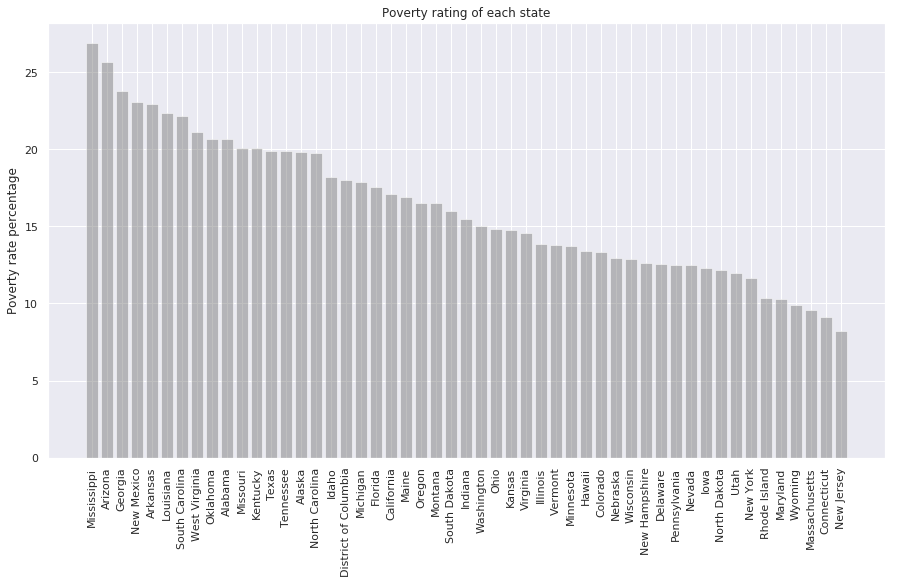

In [39]:
# Sort by poverty_rate
states_poverty_level = states_poverty_level.sort_values(by=['poverty_rate'], ascending=False)
# Create the labels
Labels = states_poverty_level['Geographic Area'].tolist()
y_pos = np.arange(len(Labels))
# Get the values of how many were killed of each gender
performance = states_poverty_level['poverty_rate'].tolist()

# Create the bar plot
plt.figure(figsize = (15, 8))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='gray')
plt.xticks(y_pos, Labels, rotation=90)
plt.ylabel('Poverty rate percentage')
plt.title('Poverty rating of each state')
 
plt.show()


By looking at the bar plot above we can see there is significant difference between the top and lowest states regarding poverty level, if we look at Mississippi and New Jersey for example there is around 18\% difference between those two states.

#### 4.4.2 Is it better to live in a place with lower poverty rate regarding fatal police shootings?

In this section we will use the information we have gathered thus far to figure out if there is any correlation between poverty rate and the number of fatal shootings. We will do so by making a scatter plot where the axis represent the poverty rate and number of fatalities in each state.

In [40]:
# Sort shootings df by state, so that we can plot it correctly
results_shootings = shootings_df
results_shootings['state'] = shootings_df['state'].apply(lambda x  : states[x] if (x in states) else x)
results_shootings = shootings_df.sort_values(by=['state'], ascending=True)
# Sort poverty rate by state
results_poverty_rate = states_poverty_level.sort_values(by=['Geographic Area'],ascending=True)

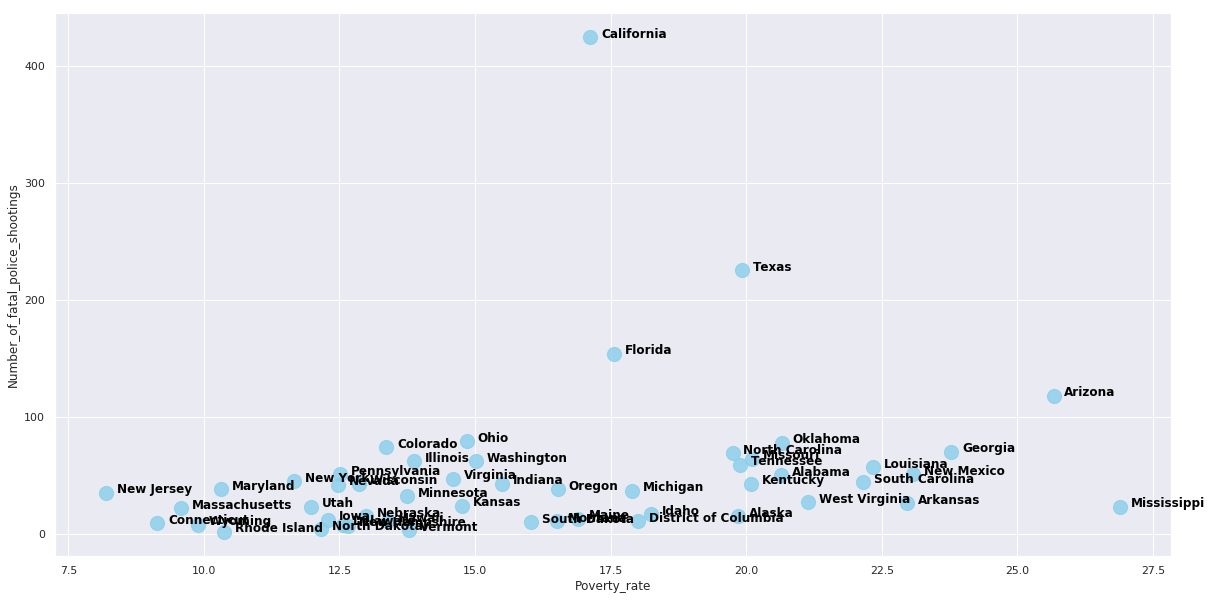

In [41]:
# Create dataframe for plotting
df = pd.DataFrame({
# Create the x-axis
'Poverty_rate': results_poverty_rate['poverty_rate'].tolist(),
# Create the y-axes
'Number_of_fatal_police_shootings': results_shootings['state'].value_counts().sort_index().tolist(),
# Create the labels for each state
'group': results_shootings['state'].value_counts().sort_index().index.tolist()
})
# Setting the size of the scatter plot
sns.set(rc={'figure.figsize':(20,10)})
# Plotting the data points
p1=sns.regplot(data=df, x="Poverty_rate", y="Number_of_fatal_police_shootings", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':200})

# Add annotations for each states
for line in range(0,df.shape[0]):
     p1.text(df.Poverty_rate[line]+0.2, df.Number_of_fatal_police_shootings[line], df.group[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

By looking at the scatter plot above we can see that there is very little if any correlation between the poverty rate and the number of fatal police shootings, if we take a look at Mississippi and New Jersey for example there is very little difference in fatal police shootings even though the difference in poverty rate between the states is significant.  

## 5. Where to live to avoid fatal police shooting conclusion

With the data we have shown above we know that the most dangerous city regarding fatal police shootings is Texas which had 225 fatal police shootings in the years 2015-2017 with the odds of being killed by the police being 0.00259 \% while the safest city regarding fatal police shootings is Rhode Island with 2 fatal police shootings in the years 2015-2017 with the probability of being in a fatal police shooting being 0.00019 \%.